##Imports and definitions

In [ ]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Check version of tensorflow
!pip install 'tensorflow==1.15.0'
import tensorflow as tf
#tf.__version__

In [ ]:
!pip install 'kaggle-environments>=0.1.6'

In [ ]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

###Environment

In [36]:
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 3/self.rows*self.columns
        elif done: # The opponent won the game
            return -42/(self.rows*self.columns)
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -420/42, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

#scoreset_A: 10/42, -100/42, 1/42, -10
#scoreset_B: 1/42, -100/42, 1/42, -420/42
#scoreset_C: 1/2*42, -210/42, 1/42, -420/42
#scoreset_D: -1/42, -300/42, 1/42, -420/42
#scoreset_E: -1/42, -300/42, 2/42, -420/42
#scoreset_F: -50/42, -300/42, 1/42, -400/42
#scoreset_G: -200/42, -300/42, 1/42, -400/42
#scoreset_H: -1/42, -200/42, 2/42, -400/42
#scoreset_J: 3/42, -42/42, 1/42, -420/42
#scoreset_O: 1, -1, 1/42, -10

In [34]:
import os
from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv

# Create directory for logging training information
log_dir = "ppo/"
os.makedirs(log_dir, exist_ok=True)

# Create ConnectFour environment
env = ConnectFourGym()

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)#, info_keywords=(['observation'])) 

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

##Training

###Build

In [35]:
from stable_baselines import PPO1, A2C,  
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy, MlpPolicy

In [14]:
#@title model_OG
# Neural network for predicting action values
def modified_cnn_OG(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_3 = conv_to_fc(layer_2)
    return activ(linear(layer_3, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy_OG(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy_OG, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn_OG)
        
# Initialize agent
model_OG = PPO1(CustomCnnPolicy_OG, vec_env, verbose=1)

In [25]:
# Neural network for predicting action values
def modified_cnn_X(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=64, filter_size=2, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(scaled_images, 'c2', n_filters=128, filter_size=2, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_3 = conv_to_fc(layer_2)
    layer_4 = activ(linear(layer_3, 'fc1', n_hidden=1024, init_scale=np.sqrt(2)))
    return activ(linear(layer_4, 'fc2', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicyX(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicyX, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn_X)
        
# Initialize agent
modelX = PPO1(CustomCnnPolicyX, vec_env, verbose=0)

In [ ]:
## RESET ENV AND MODELS
if False:
    log_dir = "ppo/"
    os.makedirs(log_dir, exist_ok=True)
    monitor_env = Monitor(env, log_dir, allow_early_resets=True)
    vec_env = DummyVecEnv([lambda: monitor_env])
    modelX = PPO1(CustomCnnPolicyX, vec_env, verbose=0)
    model_OG = PPO1(CustomCnnPolicy_OG, vec_env, verbose=0)

###Train

In [26]:
def agentX(obs, config, model=modelX, debug=False):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))

    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [27]:
# Training agents
from experimental_agent_v7 import my_agent as heuristic
from test_agent_v9 import my_agent as test_agent

agent_order_X = {0:agentX, 1:agentX, 2:agentX,
                3:agentX, 4:agentX, 5:agentX,
                6:agentX, 7:agentX, 8:agentX, 
                9:agentX} 

agent_order_A = {0:"negamax", 1:test_agent, 2:heuristic,
                3:agentX, 4:test_agent, 5:agentX,
                6:"random", 7:heuristic, 8:test_agent, 
                9:agentX}

agent_order_B = {0:"negamax", 1:test_agent, 2:heuristic,
                3:heuristic, 4:test_agent, 5:"negamax",
                6:test_agent, 7:"random", 8:heuristic}

agent_order_N = {0:"negamax", 1:"random", 2:"negamax"}

In [ ]:
# Train agent
agent_order = agent_order_A
for _ in range(10):
    for session in range(len(agent_order)): 
        start = time.time()
        nsteps = 102400 // (len(agent_order))
        env = ConnectFourGym(agent2=agent_order[session])
        modelX.learn(total_timesteps=nsteps)
        stop = time.time()
        print (nsteps,"steps against",agent_order[session],"took",
            (stop-start)// 60,"minutes and",
            round((stop-start) % 60, 2), "seconds.")
        
    # Plot cumulative reward
    with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
        firstline = fh.readline()
        assert firstline[0] == '#'
        df = pd.read_csv(fh, index_col=None)
    (df['l'].rolling(window=1024).mean() - 6).plot()
    df['r'].rolling(window=1024).mean().plot()
    plt.show()

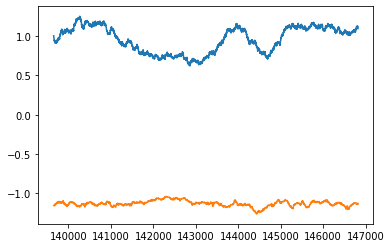

In [38]:
# Plot cumulative reward
#with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
#    firstline = fh.readline()
#    assert firstline[0] == '#'
    #df = pd.read_csv('/content/ppo/monitor.csv', index_col=None) #fh

(df['l'][-7680:].rolling(window=512).mean() - 6).plot()
df['r'][-7680:].rolling(window=512).mean().plot()
plt.show()

In [39]:
modelX.save('big_scoresetJ_100k')

In [ ]:
modelX.save('modelX')
del modelX
modelX =  PPO1.load('/content/modelX.zip', env=vec_env)

In [86]:
model_OG = A2C.load('/content/model_OG_A2C.zip', env=vec_env)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



##Evaluation

In [40]:
def get_win_percentages(agent1, agent2, n_rounds=1):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 4))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 4))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))
    return outcomes

In [47]:
def trained_agent(obs, config, model=modelX, debug=True):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    if debug:
        print("Trained model {} predicts: {}".format(obs.mark, col))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        if debug:
            print(">>> Trained model {} guesses randomly: {}".format(obs.mark, col))
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [81]:
board = np.array([0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, 0,
                  0, 0, 2, 2, 2, 1, 0,
                  0, 0, 1, 2, 2, 1, 0,
                  0, 0, 2, 1, 1, 1, 0]).reshape((6,7,1))

In [89]:
modelX.action_probability(board)

array([4.5385608e-03, 6.4647697e-02, 6.7577712e-02, 1.8929254e-02,
       8.2114214e-01, 2.2954317e-02, 2.1039565e-04], dtype=float32)

In [90]:
modelX.predict(board)

(4, None)

In [91]:
model_OG.predict(board), model_OG.action_probability(board)

((2, None), array([0.07473746, 0.03027752, 0.4408844 , 0.2556756 , 0.17304564,
        0.01038975, 0.01498962], dtype=float32))

In [52]:
start_time = time.time()
n_rounds=222
agent1 = lambda x,y: trained_agent(x,y,model=modelX,debug=False)
agent2 = lambda x,y: test_agent(x,y,debug=False)
#agent2 = agentX
#agent2 = "negamax"
outcomes = get_win_percentages(agent1, agent2, n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
Total time taken: 203.2764027118683 seconds
Time taken per round: 0.9156598969622776 seconds


In [ ]:
start_time = time.time()
n_rounds=100
agent1 = agentX 
agent2 = "random"
outcomes = get_win_percentages(agent1, agent2, n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))

In [ ]:
outcomes